In [288]:
import numpy as np
from qutip import *
from sympy.physics.quantum.cg import CG
from sympy.physics.wigner import wigner_6j, wigner_3j
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.linalg import inv
from numpy import linalg as LA
from scipy.optimize import minimize_scalar
import math
from scipy.optimize import curve_fit
from scipy.sparse.linalg import eigs,spsolve
from scipy.odr import ODR, Model, Data, RealData
import matplotlib.cm as cm

In [134]:
#toy model's qunatum numbers
I = 1
S = 1
Je = 0
Jg = 1
Lg = 2
F = [i for i in range(int(I-Jg),int(I + Jg + 1),1)]
F.insert(0,int(I+Je))
F 

[1, 0, 1, 2]

In [135]:
#number of atomic states
N = [2*F[i] + 1 for i in range(len(F))]
N = sum(N)
N

12

In [136]:
#Zeeman stuff

muB = 9.3e-24 #Bohr magneton J T^-1
hbar = 1.054e-34 # J s

muB = muB/hbar #hbar = 1
muB = muB/(2*np.pi)
muB = muB/1e6  # so it's in 1/2π (MHz T^-1)
#muB=1

# 1Gauss is 0.0001 T
B=5e-04
print(muB*B) 
#gF = [1,0,1,2]
gF = []
FF = [7,6,7,8]
II = 7


#Lande g factor for real Lu with I=7
me = 9.1093837015e-31 
mp = 1.67262192369e-27 

mI = 3.169 #nuclear magnetic moment of 176Lu in units of μN
gI = mI/II
gJg = 1 + (Jg*(Jg +1) + S*(S + 1) - Lg*(Lg + 1))/(2*Jg*(Jg + 1))


gF.append(-gI*me/mp)

for i in range(3):
    gF.append(gJg*(FF[i +1]*(FF[i+1] + 1) + Jg*(Jg+1) - II*(II+1))/(2*FF[i+1]*(FF[i +1] + 1)))

    
print(gF)

7.021541606995384
[-0.0002465559058692723, -0.07142857142857142, 0.008928571428571428, 0.0625]


In [137]:
-gI*me/mp

-0.0002465559058692723

In [138]:
for i in range(len(F)):
    print(gF[i]*muB*B) #(1/2π MHz)

-0.0017312025515115329
-0.5015386862139559
0.06269233577674449
0.4388463504372115


In [139]:
def base(F,i,mF):
    #numbering states from 0 to N-1 starting from -mF to mF
    # 0 is |F',-mF'>
    if i==0:
        b = basis(N,mF+F[i])
    elif i==1:
        b = basis(N,mF + F[i] + 2*F[0] + 1)
    elif i==2:
        b = basis(N,mF + F[i] + 2*F[0] + 1 + 2*F[1] + 1)
    else:
        b = basis(N,mF + F[i] + 2*F[0] + 1 + 2*F[1] + 1 + 2*F[2] +1)
    return b    

## Dissipation

In [141]:
GammaJgJe = 2.44745 #1/2π (MHz) 3D1 to 3P0
#GammaJgJe = 2.5

In [142]:
def GammaFgFe(F,ig,Je,Jg,I,GammaJgJe):
    return float((2*Je + 1)*(2*F[ig] + 1)*wigner_6j(Je,F[0],I,F[ig],Jg,1)**2)*GammaJgJe
    #return GammaJgJe

In [148]:
GammaFgFe(F,1,Je,Jg,I,GammaJgJe) + GammaFgFe(F,2,Je,Jg,I,GammaJgJe) + GammaFgFe(F,3,Je,Jg,I,GammaJgJe)

2.44745

In [154]:
def cg(F,ig,mFg,ie,mFe,q):
    return float(CG(F[ig],mFg,1,q,F[ie],mFe).doit())
    #return 1

In [156]:
#checking our normalization convention
for ig in range(1,len(F)):
    we=0
    for mfg in range(-F[ig],F[ig] + 1):
        for mfe in range(-F[0],F[0]+1):
            for q in [-1,0,1]:
                we+=1/(2*F[0] + 1)*cg(F,ig,mfg,0,mfe,q)**2
                
    print(we)

1.0
1.0000000000000002
1.0


In [158]:
#checking decay rates
we_ = 0
for ig in range(1,len(F)):
    we=0
    for mfg in range(-F[ig],F[ig] + 1):
        for mfe in range(-F[0],F[0]+1):
            for q in [-1,0,1]:
                we+=1/(2*F[0] + 1)*cg(F,ig,mfg,0,mfe,q)**2*GammaFgFe(F,ig,Je,Jg,I,GammaJgJe)
    print(we)
    we_+=we
print(we_)

0.27193888888888884
0.8158166666666667
1.3596944444444443
2.44745


In [160]:
#checking decay rates
for mfe in range(-F[0],F[0]+1):
    we=0
    for ig in range(1,len(F)):
        for mfg in range(-F[ig],F[ig] + 1):
            for q in [-1,0,1]:
                we+=1/(2*F[0] + 1)*cg(F,ig,mfg,0,mfe,q)**2*GammaFgFe(F,ig,Je,Jg,I,GammaJgJe)
    print(we)

0.8158166666666666
0.8158166666666666
0.8158166666666666


In [162]:
#for ig in range(1,len(F)):
#    for mFe in range(-F[0],F[0]+1):
#        for mFg in range(-F[ig],F[ig]+1):
#            for q in qs:
#                print((1/np.sqrt(2*F[0] + 1)*cg(F,ig,mFg,0,mFe,q))**-2)

In [164]:
#single collapse operator for each transtion
c_ops = []
qs = [-1,0,1]

for ig in range(1,len(F)):
    for mfg in range(-F[ig],F[ig] + 1):
        for mfe in range(-F[0], F[0] + 1):
            for q in qs:
                if cg(F,ig,mfg,0,mfe,q) != 0:
                    cops =np.sqrt(1/(2*F[0] + 1))*cg(F,ig,mfg,0,mfe,q)*np.sqrt(GammaFgFe(F,ig,Je,Jg,I,GammaJgJe))*base(F,ig,mfg)*base(F,0,mfe).dag()
                    c_ops.append(cops.to("CSR"))
                else:
                    continue

## Absorption of rest ion

In [167]:
def H_I(F,Omega_p):
    HI=0*basis(N,0)*basis(N,0).dag()
    for mFe in range(-F[0],F[0] + 1):
        for ig in range(1,len(F)):
            for mFg in range(-F[ig],F[ig]+1):
                for q in range(-1,2):
                    HI += cg(F,ig,mFg,0,mFe,q)*Omega_p[ig-1,q+1]/2*base(F,0,mFe)*base(F,ig,mFg).dag()
                
    return -1/np.sqrt(2*F[0]+1)*(HI + HI.dag()) 

In [169]:
def H_0(F,Delta):
    H0 = 0*basis(N,0)*basis(N,0).dag()
    for l in range(len(F)):
        for mF in range(-F[l],F[l]+1):
            H0 += (Delta[l] + gF[l]*muB*mF*B)*base(F,l,mF)*base(F,l,mF).dag() 
    return H0

In [171]:
def pop_e(F,N,Delta,Omega_p,c_ops,Deltap_min, Deltap_max,nn):   
    
    #number of excited states
    Ne = 2*F[0] + 1

    e = [basis(N,i) for i in range(0,Ne)]
    g = [basis(N,i) for i in range(Ne,N)]

    #Delta = [0,4*GammaJgJe,4*GammaJgJe,4*GammaJgJe + 5]
    i=0
    popes = np.zeros(nn)
    popgs = np.zeros(nn)
    rhos = []
    
    #HI - laser-ion interaction      
    HI=H_I(F,Omega_p) 

    for Deltap in tqdm(np.linspace(Dmin,Dmax,nn)):
    #for Deltap in [50,55,60,65,0]:
        
        Delta[2] = Deltap
        
        #H0 - ion
        H0 = H_0(F,Delta)
    
        #total Hamiltonian
        H = H0 + HI
        #make sure Hamiltonian is sparse
        H = H.to("CSR").tidyup(atol=1e-8)
        #print(H)
        
        rho = steadystate(H,c_ops)
        rhos.append(rho)
        
        for j in range(len(e)):
            popes[i] += expect(e[j]*e[j].dag(),rho)
            
        #for k in range(len(g)):
            #popgs[i] += expect(g[k]*g[k].dag(),rho)
    
        #print(i)
        #print(popgs[i])
        #print(popes[i])
        i+=1
        
    #return popes,popgs,rhos
    return popes

### σ+ and σ- for all transitions

In [174]:
#Rabi frequencies Ω_F,F' #1/2π (MHz)
omega = [30,5,30]

#turn on/off polarization
Omega_p= np.zeros((3,3)) # (ig-1, q + 1) transition from F[ig] state to F' with polarization q

Omega_p[0,0] = Omega_p[0,2] = omega[0]       #σ+ and σ- for F=F[1] to F'= F[0]
Omega_p[1,0] = Omega_p[1,2] = omega[1]      #σ+ and σ- for F=F[2] to F'=F[0]
Omega_p[2,0] = Omega_p[2,2] = omega[2]     #σ+ and σ- for F=F[3] to F'=F[0]

In [176]:
B = 5e-04
print(muB*B) 
Delta = [0,10,20.5,20]

#Delta[2] = Delta[3] -(gF[2] + gF[3])*muB*B

Delta

7.021541606995384


[0, 10, 20.5, 20]

In [178]:
Dmin = 17.5
Dmax = 23
NN = 2000
step = (Dmax-Dmin)/NN
step

0.00275

In [180]:
#Delta[2] for each time two individual detunings driving F[ig] mFg -> F[ie] mFe match (potential dark states)
Delta_ds = []

for mFe in range(-F[0],F[0] + 1):
    for mFg in range(-F[2],F[2] + 1):
        for q in [-1,1]:
            #print(mFg)
            if cg(F,2,mFg,0,mFe,q) != 0:
                #print(F[0],mFe)
                #print(F[2],mFg)
                #print('\n')
                for ig in [1,3]:
                    for mFFg in range(-F[ig],F[ig] + 1):
                        for qq in [-1,1]:
                        #print(mFFg)
                            if cg(F,ig,mFFg,0,mFe,qq) != 0:
                                Delta_ds.append(Delta[ig] - gF[2]*mFg*muB*B + gF[ig]*mFFg*muB*B)

In [182]:
Delta_ds.sort()
Delta_ds[-2] #detuning for chosen dark state

20.501538686213955

In [185]:
pope = pop_e(F,N,Delta,Omega_p,c_ops,Dmin,Dmax,NN)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 473.56it/s]


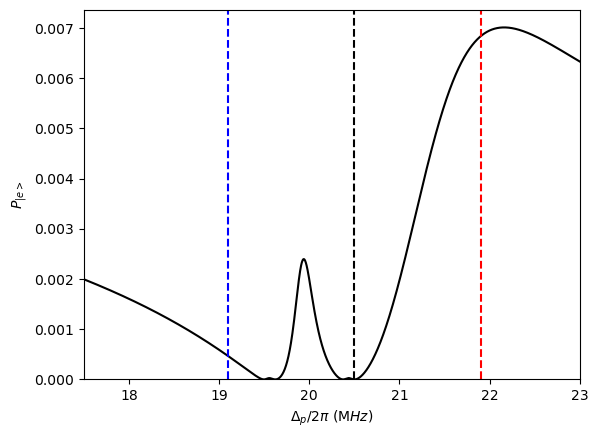

In [186]:
plt.figure()
#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(np.linspace(Dmin,Dmax,NN),pope,color='black')
#for i in range(len(Delta_ds)):
    #plt.axvline(Delta_ds[i], linestyle=(0, (1, 10)))
plt.ylabel('$P_{|e>}$')
plt.xlabel('$Δ_{p}/2π \ (ΜHz)$')
plt.ylim(0)
plt.axvline(Delta_ds[-2] + 1.4, linestyle='--',color='red')
plt.axvline(Delta_ds[-2], linestyle='--',color='black')
plt.axvline(Delta_ds[-2] - 1.4, linestyle='--',color='blue')
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
plt.xlim(17.5,23)

#plt.savefig("I1_abs_1_ds.png",bbox_inches = "tight")
plt.show()

In [187]:
#Rabi frequencies Ω_F,F' #1/2π (MHz)
omega = [23.5,10,23.5]

#turn on/off polarization
Omega_p= np.zeros((3,3)) # (ig-1, q + 1) transition from F state to F' with polarization q

Omega_p[0,0] = Omega_p[0,2] = omega[0]       #σ+ and σ- for F=F[1] to F'= F[0]
Omega_p[1,0] = Omega_p[1,2] = omega[1]      #σ+ and σ- for F=F[2] to F'=F[0]
Omega_p[2,0] = Omega_p[2,2] = omega[2]     #σ+ and σ- for F=F[3] to F'=F[0]

In [188]:
B = 5e-04
print(muB*B) 
Delta = [0,10,20.5,20]

#Delta[2] = Delta[3] -(gF[2] + gF[3])*muB*B

Delta

7.021541606995384


[0, 10, 20.5, 20]

In [189]:
pope1 = pop_e(F,N,Delta,Omega_p,c_ops,Dmin,Dmax,NN)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 482.65it/s]


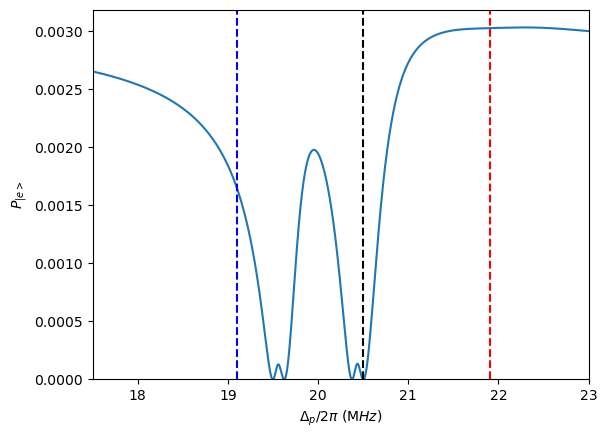

In [190]:
plt.figure()
#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(np.linspace(Dmin,Dmax,NN),pope1)
#for i in range(len(Delta_ds)):
    #plt.axvline(Delta_ds[i], linestyle=(0, (1, 10)))
plt.ylabel('$P_{|e>}$')
plt.xlabel('$Δ_{p}/2π \ (ΜHz)$')
plt.ylim(0)
plt.axvline(Delta_ds[-2] + 1.4, linestyle='--',color='red')
plt.axvline(Delta_ds[-2], linestyle='--',color='black')
plt.axvline(Delta_ds[-2] - 1.4, linestyle='--',color='blue')
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
plt.xlim(17.5,23)
#plt.savefig("Lu_eit_e_pi.png",bbox_inches = "tight")
plt.show()

In [195]:
#Rabi frequencies Ω_F,F' #1/2π (MHz)
omega = [23,8,23]

#turn on/off polarization
Omega_p= np.zeros((3,3)) # (ig-1, q + 1) transition from F state to F' with polarization q

Omega_p[0,0] = Omega_p[0,2] = omega[0]       #σ+ and σ- for F=F[1] to F'= F[0]
Omega_p[1,0] = Omega_p[1,2] = omega[1]      #σ+ and σ- for F=F[2] to F'=F[0]
Omega_p[2,0] = Omega_p[2,2] = omega[2]     #σ+ and σ- for F=F[3] to F'=F[0]

In [196]:
pope2 = pop_e(F,N,Delta,Omega_p,c_ops,Dmin,Dmax,NN)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 480.86it/s]


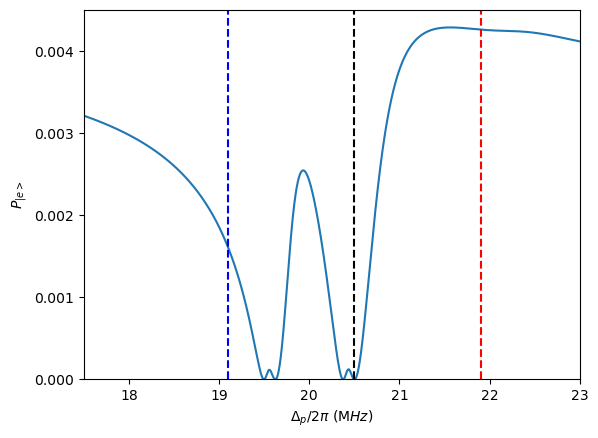

In [197]:
plt.figure()
#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(np.linspace(Dmin,Dmax,NN),pope2)
#for i in range(len(Delta_ds)):
    #plt.axvline(Delta_ds[i], linestyle=(0, (1, 10)))
plt.ylabel('$P_{|e>}$')
plt.xlabel('$Δ_{p}/2π \ (ΜHz)$')
plt.ylim(0)
plt.axvline(Delta_ds[-2] + 1.4, linestyle='--',color='red')
plt.axvline(Delta_ds[-2], linestyle='--',color='black')
plt.axvline(Delta_ds[-2] - 1.4, linestyle='--',color='blue')
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
plt.xlim(17.5,23)
#plt.savefig("Lu_eit_e_pi.png",bbox_inches = "tight")
plt.show()

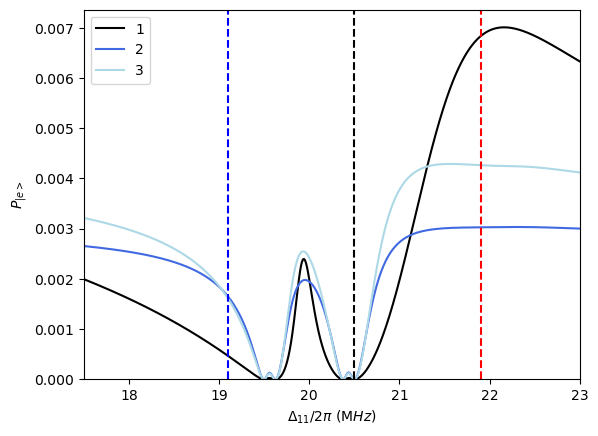

In [198]:
plt.figure()
#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(np.linspace(Dmin,Dmax,NN),pope,label='1',color='black')
plt.plot(np.linspace(Dmin,Dmax,NN),pope1,label='2',color='royalblue')
plt.plot(np.linspace(Dmin,Dmax,NN),pope2,label='3',color='lightblue')
plt.ylabel('$P_{|e>}$')
plt.xlabel('$Δ_{11}/2π \ (ΜHz)$')
plt.ylim(0)
plt.axvline(Delta_ds[-2]+1.4, linestyle='--',color='red')
plt.axvline(Delta_ds[-2], linestyle='--',color='black')
plt.axvline(Delta_ds[-2]- 1.4, linestyle='--',color='blue')
plt.xlim(17.5,23)
plt.legend()
#plt.savefig("abs_1_compare_extra_lasers_eta_1e4.png",bbox_inches = "tight")

plt.show()

In [199]:
eta = 0.044
omega0 = 1.4
GammaJgJe

2.44745

In [200]:
pope[int((Delta_ds[-2]+omega0-Dmin)/step)] - pope[int((Delta_ds[-2]-omega0-Dmin)/step)]

0.006370607607157511

In [201]:
pope1[int((Delta_ds[-2]+omega0-Dmin)/step)] - pope1[int((Delta_ds[-2]-omega0-Dmin)/step)]

0.0013812379309392905

In [202]:
pope2[int((Delta_ds[-2]+omega0-Dmin)/step)] - pope2[int((Delta_ds[-2]-omega0-Dmin)/step)]

0.0026565438532405007

In [204]:
wabs = np.array([pope[int((Delta_ds[-2]+omega0-Dmin)/step)] - pope[int((Delta_ds[-2]-omega0-Dmin)/step)],
                pope2[int((Delta_ds[-2]+omega0-Dmin)/step)] - pope2[int((Delta_ds[-2]-omega0-Dmin)/step)],
                pope1[int((Delta_ds[-2]+omega0-Dmin)/step)] - pope1[int((Delta_ds[-2]-omega0-Dmin)/step)]])
wabs = 2*np.pi*GammaJgJe*eta**2*wabs

In [207]:
wabs

array([1.89661816e-04, 7.90889917e-05, 4.11213672e-05])

## Fictitious lasers

In [208]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [209]:
def H1_(F,eta,Omega_p):
    H1=0*basis(N,0)*basis(N,0).dag()
    for mFe in range(-F[0],F[0] + 1):
        for ig in range(1,len(F)):
            for mFg in range(-F[ig],F[ig]+1):
                for q in range(-1,2):
                    H1 += eta[ig-1]*cg(F,ig,mFg,0,mFe,q)*Omega_p[ig-1,q+1]/2*base(F,0,mFe)*base(F,ig,mFg).dag()
                
    return -1/np.sqrt(2*F[0]+1)*H1

In [210]:
def steck(F,N,Delta,Omega_p,eta,c,Dmin, Dmax,nn):
    H0_ = H_0(F,Delta)
    HI_ = H_I(F,Omega_p) 
    

    H0 = H0_ + HI_ 
    #H0 = H0.to("CSR").tidyup(atol=1e-8)

    rho0 = steadystate(H0,c)

    L0 = 0*spre(c[0])*spost(c[0].dag())
    for i in range(len(c)):
        L0 += spre(c[i])*spost(c[i].dag()) - 0.5*(spre(c[i].dag()*c[i]) + spost(c[i].dag()*c[i]))
    #L0 = sum(c)

    L0 += -1j*(spre(H0) - spost(H0))
    
    #L0 = np.array(L0)
    L0 = L0.data_as('ndarray')

    H_1 = H1_(F,eta,Omega_p)
    L_1 = -1j*(spre(H_1) - spost(H_1))

    #L_1 = np.array(L_1)
    L_1 = L_1.data_as('ndarray')

    H1 = H_1.dag()
    L1 = -1j*(spre(H1) - spost(H1))

    #L1 = np.array(L1)
    L1 = L1.data_as('ndarray')
   
    #popes = np.zeros(nn,dtype='complex64')
    #coh = np.zeros(nn,dtype='complex64')
    abs = np.zeros(nn,dtype='complex64')
    
    k=0

    for Deltap in tqdm(np.linspace(Dmin,Dmax,nn)):


        #S3 = -np.matmul(inv(L0-3j*Deltap*np.eye(N**2)),L1)
        S2 = -np.matmul(inv(L0-2j*Deltap*np.eye(N**2)),L1)
        #S2 = -np.matmul(inv(L0-2j*Deltap*np.eye(N**2)+ np.matmul(L_1,S3)),L1)
        S1 = -np.matmul(inv(L0-1j*Deltap*np.eye(N**2) + np.matmul(L_1,S2)),L1)
        #S1 = -np.matmul(inv(L0-1j*Deltap*np.eye(N**2)),L1) 

        #T_3 = -np.matmul(inv(L0+3j*Deltap*np.eye(N**2)),L_1)
        T_2 = -np.matmul(inv(L0+2j*Deltap*np.eye(N**2)),L_1)
        #T_2 = -np.matmul(inv(L0+2j*Deltap*np.eye(N**2)+ np.matmul(L1,T_3)),L_1)
        T_1 = -np.matmul(inv(L0+1j*Deltap*np.eye(N**2)+ np.matmul(L1,T_2)),L_1)
        #T_1 = -np.matmul(inv(L0+1j*Deltap*np.eye(N**2)),L_1)
    
        L = np.matmul(L_1,S1) + L0 +np.matmul(L1,T_1)
    
        eigenvalues, eigenvectors = eigs(L,k=1,sigma = 0+0j)

        rhoss = eigenvectors[:,0]

        rhos = np.zeros((N,N),dtype='complex64')
        for i in range(N):
            for j in range(N):
                rhos[j,i] = rhoss[j+i*N]

        rho = Qobj(rhos)
        if rho.tr() != 0:
            rho = rho/rho.tr()

        rho_ = operator_to_vector(rho)
        #rho_ = np.array(rho_)
        rho_ = rho_.data_as('ndarray')

        rho1 = np.matmul(S1,rho_)
        #rho2 = np.matmul(S2,rho_)
        #rho3 = np.matmul(S3,rho_)

        rho_1 = np.matmul(T_1,rho_)
        #rho_2 = np.matmul(T_2,rho_)
        #rho_3 = np.matmul(T_3,rho_)

        rhos1 = np.zeros((N,N),dtype='complex64')
        #rhos2 = np.zeros((N,N),dtype='complex64')
        #rhos3 = np.zeros((N,N),dtype='complex64')
        rhos_1 = np.zeros((N,N),dtype='complex64')
        #rhos_2 = np.zeros((N,N),dtype='complex64')
        #rhos_3 = np.zeros((N,N),dtype='complex64')
        for i in range(N):
            for j in range(N):
                rhos1[j,i] = rho1[j+i*N]
                #rhos2[j,i] = rho2[j+i*N]
                #rhos3[j,i] = rho3[j+i*N]
                rhos_1[j,i] = rho_1[j+i*N]
                #rhos_2[j,i] = rho_2[j+i*N]
                #rhos_3[j,i] = rho_3[j+i*N]
            
        Rho1 = Qobj(rhos1)
        #Rho2 = Qobj(rhos2)
        #Rho3 = Qobj(rhos3)
        Rho_1 = Qobj(rhos_1)
        #Rho_2 = Qobj(rhos_2)
        #Rho_3 = Qobj(rhos_3)

        #ree = 0+0j
        #rcoh = 0+0j
        rabs= 0+0j
        for ig in range(1,len(F)):
            for mfg in range(-F[ig],F[ig] + 1):
                for mfe in range(-F[0],F[0]+1):
                    for q in range(-1,2):
                        #ree+=2*np.pi*1/(2*F[0] + 1)*cg(F,ig,mfg,0,mfe,q)**2*GammaFgFe(F,ig,Je,Jg,I,GammaJgJe)*(
                            #expect(base(F,0,mfe)*base(F,0,mfe).dag(),rho))

                        #rcoh+=-1j*2*np.pi*cg(F,ig,mfg,0,mfe,q)*Omega_p[ig-1,q+1]/2*1/np.sqrt(2*F[0]+1)*(
                            #expect(base(F,ig,mfg)*base(F,0,mfe).dag(),rho) -(
                                #expect(base(F,0,mfe)*base(F,ig,mfg).dag(),rho)))

                        rabs+=-1j*2*np.pi*eta[ig-1]*cg(F,ig,mfg,0,mfe,q)*Omega_p[ig-1,q+1]/2*1/np.sqrt(2*F[0]+1)*(
                            expect(base(F,ig,mfg)*base(F,0,mfe).dag(),Rho_1)-expect(base(F,0,mfe)*base(F,ig,mfg).dag(),Rho1))

        #popes[k] = ree
        #coh[k] = rcoh
        abs[k] = rabs
        k+=1
        

    return abs

In [211]:
#system parameters
c = 299792458
λ = 646e-9
f = c/λ 
f_1 = 11.2e9
f_2 = 10.5e9

#176Lu+
amu = 1.66053886e-27
hbar = 1.054571817e-34
M = 176*amu

omega0  = 1.4

eta = []

eta2 = 2*np.pi*f/c*np.sqrt(hbar/(2*M*2*np.pi*omega0*10**(6)))
eta.append(eta2)

eta3 = 2*np.pi*(f-f_1)/c*np.sqrt(hbar/(2*M*2*np.pi*omega0*10**(6)))
eta.append(eta3)

eta4 = -2*np.pi*(f-f_2)/c*np.sqrt(hbar/(2*M*2*np.pi*omega0*10**(6)))
eta.append(eta4)

#eta = [0.01,0.01,-0.01]
#eta = [1e-4,1e-4,-1e-4]
#eta = [1e-8,1e-8,-1e-8]
#eta = [0.1,0.1,-0.1]
eta

[0.044048956567528934, 0.0440478934887154, -0.04404795993114125]

In [212]:
#Rabi frequencies Ω_F,F' #1/2π (MHz)
omega = [30,5,30]

#turn on/off polarization
Omega_p= np.zeros((3,3)) # (ig-1, q + 1) transition from F[ig] state to F' with polarization q

Omega_p[0,0] = Omega_p[0,2] = omega[0]       #σ+ and σ- for F=F[1] to F'= F[0]
Omega_p[1,0] = Omega_p[1,2] = omega[1]      #σ+ and σ- for F=F[2] to F'=F[0]
Omega_p[2,0] = Omega_p[2,2] = omega[2]     #σ+ and σ- for F=F[3] to F'=F[0]

B = 5e-04
Delta = [0,10,Delta_ds[-2],20]

Dmin_ = -2.5
Dmax_ = 2.5
nn_ = 2000
step = (Dmax_-Dmin_)/nn_
print(step)

params = dict(F=F,N=N,Delta=Delta,Omega_p=Omega_p,eta=eta,c=c_ops,Dmin=Dmin_, Dmax=Dmax_,nn=nn_)

0.0025


In [213]:
Delta 

[0, 10, 20.501538686213955, 20]

In [216]:
abs = steck(**params)

  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]C:\Users\kfouka\AppData\Local\Temp\ipykernel_10348\3405167121.py:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos1[j,i] = rho1[j+i*N]
C:\Users\kfouka\AppData\Local\Temp\ipykernel_10348\3405167121.py:92: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos_1[j,i] = rho_1[j+i*N]
100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:17<00:00, 25.79it/s]


C:\Users\kfouka\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\kfouka\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


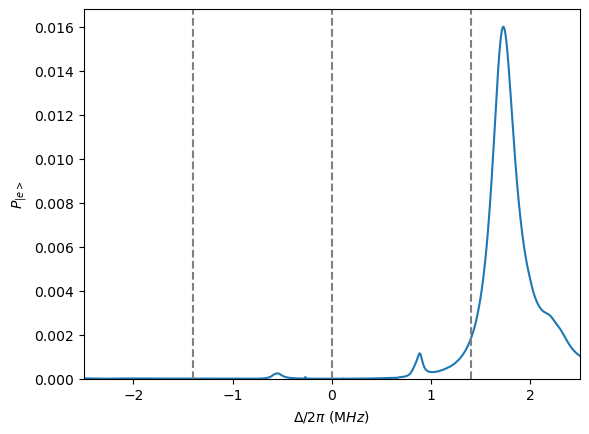

In [230]:
plt.figure()
#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(np.linspace(Dmin_,Dmax_,nn_),abs)
#plt.plot(np.linspace(Dmin,Dmax,nn),np.sum(pop_es_h,axis=0),'--')
plt.ylabel('$P_{|e>}$')
plt.xlabel('$Δ/2π \ (ΜHz)$')
plt.axvline(1.4, linestyle='--',color='grey')
plt.axvline(0, linestyle='--',color='grey')
plt.axvline(- 1.4, linestyle='--',color='grey')
plt.ylim(0)
#plt.legend()

plt.xlim(-2.5,2.5)

#plt.savefig("Lu_eit_e_pi.png",bbox_inches = "tight")
plt.show()

In [231]:
#Rabi frequencies Ω_F,F' #1/2π (MHz)
omega = [23.5,10,23.5]

#turn on/off polarization
Omega_p= np.zeros((3,3)) # (ig-1, q + 1) transition from F[ig] state to F' with polarization q

Omega_p[0,0] = Omega_p[0,2] = omega[0]       #σ+ and σ- for F=F[1] to F'= F[0]
Omega_p[1,0] = Omega_p[1,2] = omega[1]      #σ+ and σ- for F=F[2] to F'=F[0]
Omega_p[2,0] = Omega_p[2,2] = omega[2]     #σ+ and σ- for F=F[3] to F'=F[0]

B = 5e-04
Delta = [0,10,Delta_ds[-2],20]

Dmin_ = -2.5
Dmax_ = 2.5
nn_ = 2000
step = (Dmax_-Dmin_)/nn_
print(step)

params = dict(F=F,N=N,Delta=Delta,Omega_p=Omega_p,eta=eta,c=c_ops,Dmin=Dmin_, Dmax=Dmax_,nn=nn_)

0.0025


In [232]:
abs1 = steck(**params)

  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]C:\Users\kfouka\AppData\Local\Temp\ipykernel_10348\3405167121.py:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos1[j,i] = rho1[j+i*N]
C:\Users\kfouka\AppData\Local\Temp\ipykernel_10348\3405167121.py:92: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos_1[j,i] = rho_1[j+i*N]
100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:17<00:00, 25.79it/s]


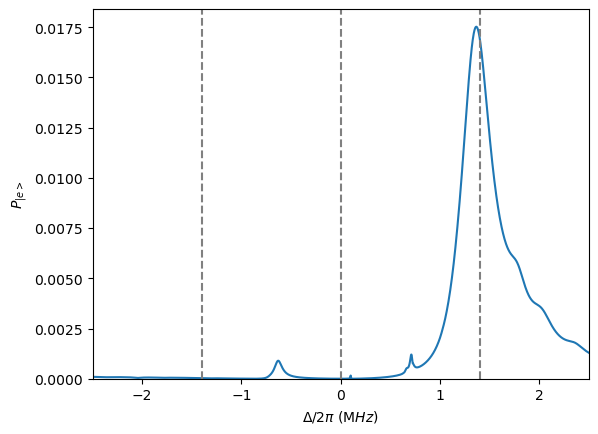

In [233]:
plt.figure()
#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(np.linspace(Dmin_,Dmax_,nn_),abs1)
#plt.plot(np.linspace(Dmin,Dmax,nn),np.sum(pop_es_h,axis=0),'--')
plt.ylabel('$P_{|e>}$')
plt.xlabel('$Δ/2π \ (ΜHz)$')
plt.axvline(1.4, linestyle='--',color='grey')
plt.axvline(0, linestyle='--',color='grey')
plt.axvline(- 1.4, linestyle='--',color='grey')
plt.ylim(0)
#plt.legend()

plt.xlim(-2.5,2.5)

#plt.savefig("Lu_eit_e_pi.png",bbox_inches = "tight")
plt.show()

In [234]:
#Rabi frequencies Ω_F,F' #1/2π (MHz)
omega = [23,8,23]

#turn on/off polarization
Omega_p= np.zeros((3,3)) # (ig-1, q + 1) transition from F[ig] state to F' with polarization q

Omega_p[0,0] = Omega_p[0,2] = omega[0]       #σ+ and σ- for F=F[1] to F'= F[0]
Omega_p[1,0] = Omega_p[1,2] = omega[1]      #σ+ and σ- for F=F[2] to F'=F[0]
Omega_p[2,0] = Omega_p[2,2] = omega[2]     #σ+ and σ- for F=F[3] to F'=F[0]

B = 5e-04
Delta = [0,10,Delta_ds[-2],20]

Dmin_ = -2.5
Dmax_ = 2.5
nn_ = 2000
step = (Dmax_-Dmin_)/nn_
print(step)

params = dict(F=F,N=N,Delta=Delta,Omega_p=Omega_p,eta=eta,c=c_ops,Dmin=Dmin_, Dmax=Dmax_,nn=nn_)

0.0025


In [235]:
abs2 = steck(**params)

  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]C:\Users\kfouka\AppData\Local\Temp\ipykernel_10348\3405167121.py:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos1[j,i] = rho1[j+i*N]
C:\Users\kfouka\AppData\Local\Temp\ipykernel_10348\3405167121.py:92: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos_1[j,i] = rho_1[j+i*N]
100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:16<00:00, 26.13it/s]


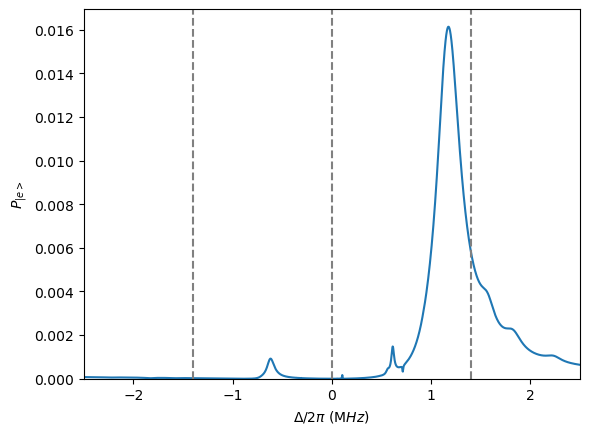

In [236]:
plt.figure()
#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(np.linspace(Dmin_,Dmax_,nn_),abs2)
#plt.plot(np.linspace(Dmin,Dmax,nn),np.sum(pop_es_h,axis=0),'--')
plt.ylabel('$P_{|e>}$')
plt.xlabel('$Δ/2π \ (ΜHz)$')
plt.axvline(1.4, linestyle='--',color='grey')
plt.axvline(0, linestyle='--',color='grey')
plt.axvline(- 1.4, linestyle='--',color='grey')
plt.ylim(0)
#plt.legend()

plt.xlim(-2.5,2.5)

#plt.savefig("Lu_eit_e_pi.png",bbox_inches = "tight")
plt.show()

In [60]:
abs[int((omega0-Dmin_)/step)] - abs[int((-omega0-Dmin_)/step)]

(0.0018110832-9.7273384e-11j)

In [61]:
abs1[int((omega0-Dmin_)/step)] - abs1[int((-omega0-Dmin_)/step)]

(0.016925426+7.054309e-10j)

In [62]:
abs2[int((omega0-Dmin_)/step)] - abs2[int((-omega0-Dmin_)/step)]

(0.0058180713+4.028114e-11j)

In [63]:
w_tilde = np.array([(abs[int((omega0-Dmin_)/step)] - abs[int((-omega0-Dmin_)/step)]).real,
                   (abs2[int((omega0-Dmin_)/step)] - abs2[int((-omega0-Dmin_)/step)]).real,
                   (abs1[int((omega0-Dmin_)/step)] - abs1[int((-omega0-Dmin_)/step)]).real])

In [64]:
w_tilde

array([0.00181108, 0.00581807, 0.01692543], dtype=float32)

## Fluctuation Spectrum

In [247]:
def H_I_(F,Omega_p):
    HI=0*basis(N,0)*basis(N,0).dag()
    for mFe in range(-F[0],F[0] + 1):
        for ig in range(1,len(F)):
            for mFg in range(-F[ig],F[ig]+1):
                for q in range(-1,2):
                    HI += 2*np.pi*cg(F,ig,mFg,0,mFe,q)*Omega_p[ig-1,q+1]/2*base(F,0,mFe)*base(F,ig,mFg).dag()
                
    return -1/np.sqrt(2*F[0]+1)*(HI + HI.dag()) 

In [249]:
def H_0_(F,Delta):
    H0 = 0*basis(N,0)*basis(N,0).dag()
    for l in range(len(F)):
        for mF in range(-F[l],F[l]+1):
            H0 += 2*np.pi*(Delta[l] + gF[l]*muB*mF*B)*base(F,l,mF)*base(F,l,mF).dag() 
    return H0

In [251]:
def H_1(F,Omega_p):
    HI=0*basis(N,0)*basis(N,0).dag()
    for mFe in range(-F[0],F[0] + 1):
        for ig in range(1,len(F)):
            for mFg in range(-F[ig],F[ig]+1):
                for q in range(-1,2):
                    HI += -eta[ig-1]*2*np.pi*cg(F,ig,mFg,0,mFe,q)*Omega_p[ig-1,q+1]/2*base(F,0,mFe)*base(F,ig,mFg).dag()
                
    return 1/np.sqrt(2*F[0]+1)*(HI + HI.dag()) 

In [253]:
#single collapse operator for each transtion
#GammaJgJe=GammaJgJe
c_ops_ = []
qs = [-1,0,1]

for ig in range(1,len(F)):
    for mfg in range(-F[ig],F[ig] + 1):
        for mfe in range(-F[0], F[0] + 1):
            for q in qs:
                if cg(F,ig,mfg,0,mfe,q) != 0:
                    cops =np.sqrt(1/(2*F[0] + 1))*cg(F,ig,mfg,0,mfe,q)*np.sqrt(GammaFgFe(F,ig,Je,Jg,I,2*np.pi*GammaJgJe))*base(F,ig,mfg)*base(F,0,mfe).dag()
                    c_ops_.append(cops)
                else:
                    continue

In [296]:
def S_(F,Delta,Omega_p,omega0,c):
    H0_ = H_0_(F,Delta)
    HI_ = H_I_(F,Omega_p) 
    

    H0 = H0_ + HI_ 
    

    L0 = 0*spre(c[0])*spost(c[0].dag())
    for i in range(len(c)):
        L0 += spre(c[i])*spost(c[i].dag()) - 0.5*(spre(c[i].dag()*c[i]) + spost(c[i].dag()*c[i]))

    L0 += -1j*(spre(H0) - spost(H0))
    
    #L0 = np.array(L0)
    L0 = L0.data_as('ndarray')

    #H0 = H0.to("CSR").tidyup(atol=1e-8)

    rho = steadystate(H0,c) #!

    V1 = H_1(F,Omega_p)
    V1rho = V1*rho 
    
    V1rho = operator_to_vector(V1rho)
    #V1rho = np.array(V1rho)
    V1rho = V1rho.data_as('ndarray')

    #eye = np.array(operator_to_vector(tensor(qeye(N),qeye(Nmotion))))
    eye = np.eye(N**2,dtype=np.complex_)
    #inve = -inv((L0+1j*2*np.pi*omega0*eye))

    #s = inve@V1rho
    s = -spsolve(L0+1j*2*np.pi*omega0*eye,V1rho)

    S = np.zeros((N,N),dtype=np.complex_)
    for i in range(N):
        for j in range(N):
            #S[j,i] = s[N*i+j][0]
            S[j,i] = s[N*i+j]
            
    #V1 = np.array(V1)
    V1 =V1.data_as('ndarray')
    S = np.matmul(V1,S)

    return np.matrix.trace(S)

In [298]:
#Rabi frequencies Ω_F,F' #1/2π (MHz)
omega = [30,5,30]

#turn on/off polarization
Omega_p= np.zeros((3,3)) # (ig-1, q + 1) transition from F[ig] state to F' with polarization q

Omega_p[0,0] = Omega_p[0,2] = omega[0]       #σ+ and σ- for F=F[1] to F'= F[0]
Omega_p[1,0] = Omega_p[1,2] = omega[1]      #σ+ and σ- for F=F[2] to F'=F[0]
Omega_p[2,0] = Omega_p[2,2] = omega[2]     #σ+ and σ- for F=F[3] to F'=F[0]

B = 5e-04
Delta = [0,10,Delta_ds[-2],20]

omega0=1.4

params = dict(F=F,Delta=Delta,Omega_p=Omega_p,omega0=omega0,c=c_ops_)

In [270]:
Ss = []
for v in tqdm(np.linspace(-2,2,1000)):
    Ss.append(S_(F=F,Delta=Delta,Omega_p=Omega_p,omega0=v,c=c_ops_))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:38<00:00, 10.15it/s]


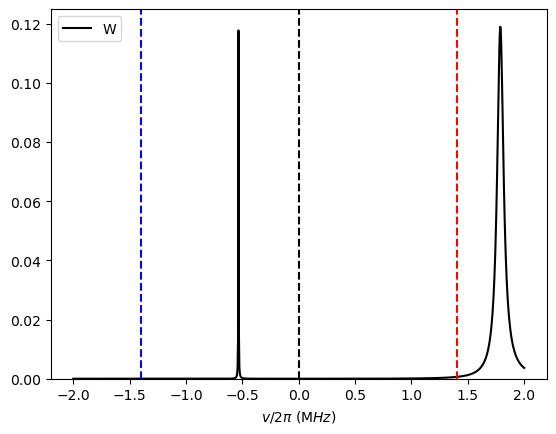

In [74]:
plt.figure()
#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(np.linspace(-2,2,1000),Ss,label='W',color='black')
plt.xlabel('$v /2π \ (ΜHz)$')
plt.ylim(0)
plt.axvline(1.4, linestyle='--',color='red')
plt.axvline(0, linestyle='--',color='black')
plt.axvline(- 1.4, linestyle='--',color='blue')

#plt.xlim(18,28)
plt.legend()


plt.show()

In [75]:
A_m = S_(F=F,Delta=Delta,Omega_p=Omega_p,omega0=omega0,c=c_ops_)
A_p = S_(F=F,Delta=Delta,Omega_p=Omega_p,omega0=-omega0,c=c_ops_)
(2*A_m-2*A_p).real

0.0012183703996212782

In [76]:
#Rabi frequencies Ω_F,F' #1/2π (MHz)
omega = [23.5,10,23.5]

#turn on/off polarization
Omega_p= np.zeros((3,3)) # (ig-1, q + 1) transition from F state to F' with polarization q

Omega_p[0,0] = Omega_p[0,2] = omega[0]       #σ+ and σ- for F=F[1] to F'= F[0]
Omega_p[1,0] = Omega_p[1,2] = omega[1]      #σ+ and σ- for F=F[2] to F'=F[0]
Omega_p[2,0] = Omega_p[2,2] = omega[2]     #σ+ and σ- for F=F[3] to F'=F[0]

B = 5e-04
Delta = [0,10,Delta_ds[-2],20]

omega0=1.4

In [77]:
Ss1 = []
for v in tqdm(np.linspace(-2,2,1000)):
    Ss1.append(S_(F=F,Delta=Delta,Omega_p=Omega_p,omega0=v,c=c_ops_))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:55<00:00,  5.71it/s]


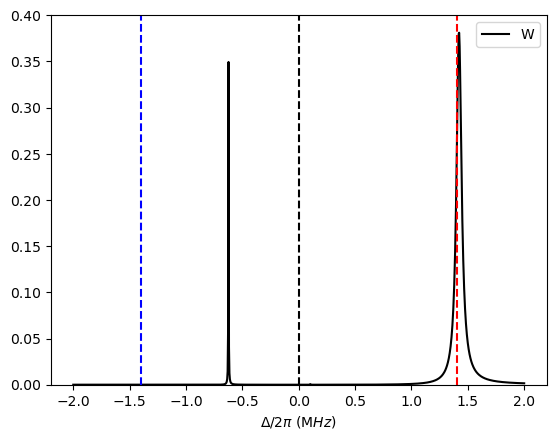

In [78]:
plt.figure()
#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(np.linspace(-2,2,1000),Ss1,label='W',color='black')
plt.xlabel('$Δ/2π \ (ΜHz)$')
plt.ylim(0)
plt.axvline(1.4, linestyle='--',color='red')
plt.axvline(0, linestyle='--',color='black')
plt.axvline(- 1.4, linestyle='--',color='blue')

#plt.xlim(18,28)
plt.legend()

plt.show()

In [79]:
A_m1 = S_(F=F,Delta=Delta,Omega_p=Omega_p,omega0=omega0,c=c_ops_)
A_p1 = S_(F=F,Delta=Delta,Omega_p=Omega_p,omega0=-omega0,c=c_ops_)

In [80]:
(2*A_m1-2*A_p1).real

0.4631414700398819

In [81]:
#Rabi frequencies Ω_F,F' #1/2π (MHz)
omega = [23,8,23]

#turn on/off polarization
Omega_p= np.zeros((3,3)) # (ig-1, q + 1) transition from F state to F' with polarization q

Omega_p[0,0] = Omega_p[0,2] = omega[0]       #σ+ and σ- for F=F[1] to F'= F[0]
Omega_p[1,0] = Omega_p[1,2] = omega[1]      #σ+ and σ- for F=F[2] to F'=F[0]
Omega_p[2,0] = Omega_p[2,2] = omega[2]     #σ+ and σ- for F=F[3] to F'=F[0]

B = 5e-04
Delta = [0,10,Delta_ds[-2],20]

omega0=1.4

In [82]:
Ss2 = []
for v in tqdm(np.linspace(-2,2,1000)):
    Ss2.append(S_(F=F,Delta=Delta,Omega_p=Omega_p,omega0=v,c=c_ops_))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:53<00:00,  5.76it/s]


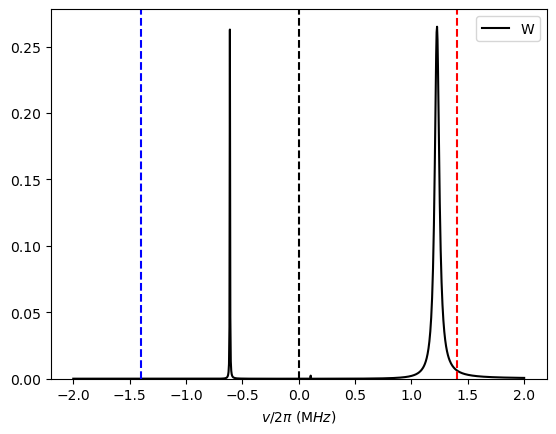

In [83]:
plt.figure()
#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(np.linspace(-2,2,1000),Ss2,label='W',color='black')
#plt.plot(np.linspace(Dmin_,Dmax_,nn_),pop_es2,label='extra lasers')
#plt.plot(np.linspace(Dmin,Dmax,nn),np.sum(pop_es,axis=0),label='extra lasers')
plt.xlabel('$v/2π \ (ΜHz)$')
plt.ylim(0)
plt.axvline(1.4, linestyle='--',color='red')
plt.axvline(0, linestyle='--',color='black')
plt.axvline(- 1.4, linestyle='--',color='blue')

#plt.xlim(18,28)
plt.legend()


plt.show()

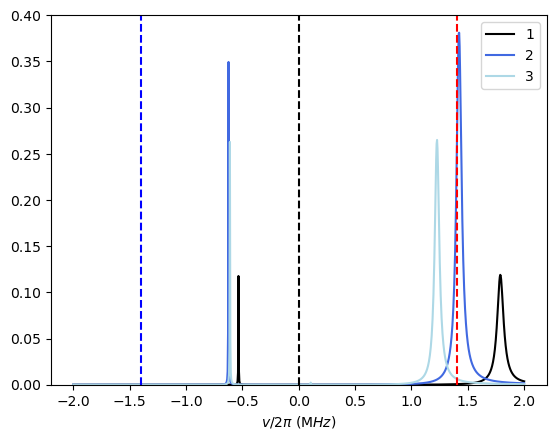

In [84]:
plt.figure()
#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(np.linspace(-2,2,1000),Ss,label='1',color='black')
plt.plot(np.linspace(-2,2,1000),Ss1,label='2',color='royalblue')
plt.plot(np.linspace(-2,2,1000),Ss2,label='3',color='lightblue')
plt.xlabel('$v/2π \ (ΜHz)$')
plt.ylim(0)
plt.axvline(1.4, linestyle='--',color='red')
plt.axvline(0, linestyle='--',color='black')
plt.axvline(- 1.4, linestyle='--',color='blue')

#plt.xlim(18,28)
plt.legend()
#plt.savefig("abs_1_compare_extra_lasers_eta_1e4.png",bbox_inches = "tight")

plt.show()

In [85]:
A_m2 = S_(F=F,Delta=Delta,Omega_p=Omega_p,omega0=omega0,c=c_ops_)
A_p2 = S_(F=F,Delta=Delta,Omega_p=Omega_p,omega0=-omega0,c=c_ops_)

In [86]:
(2*A_m2-2*A_p2).real

0.012823093217504272

In [87]:
w = np.array([(2*A_m-2*A_p).real,(2*A_m2-2*A_p2).real,(2*A_m1-2*A_p1).real])

In [88]:
w

array([0.00121837, 0.01282309, 0.46314147])

## Cooling

In [90]:
from scipy.optimize import minimize_scalar

In [91]:
def func(x,Nmax,nbar):
    
    Z = (1-np.exp(-(Nmax+1)*x))/(1-np.exp(-x))
    n = np.exp(-Nmax*x)*(np.exp((Nmax + 1)*x) -(Nmax+1)*np.exp(x) + Nmax)/(np.exp(x) -1)**2
    
    
    return np.abs(nbar - n/Z)

In [92]:
Nmax=14
nbar=3
res = minimize_scalar(func,args=(Nmax,nbar),bounds=(0, 1), method='bounded')

In [93]:
x = res.x

In [94]:
hbar = 1.054571817e-34
kB = 1.380649e-23
omega = 2*np.pi*1.4*10e6
#x = 0.184132
Z = (1-np.exp(-(Nmax+1)*x))/(1-np.exp(-x))

T = hbar*omega/(kB*x)
T

0.002527075613606284

In [95]:
P = []
for i in range(Nmax+1): #Nmotion=15 but for <n> =3 keep up to i=10
    P.append(np.exp(-i*x)/Z)

In [96]:
Pn = []
for i in range(Nmax+1):
    Pn.append(np.exp(-i*x)/Z*i)

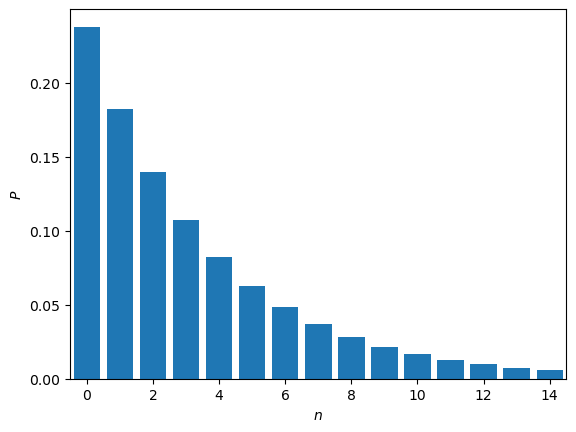

In [97]:
plt.figure()
plt.bar(np.arange(0,Nmax+1),P)
plt.ylabel('$P$')
plt.xlabel('$n$')
plt.xlim(-0.5,Nmax+0.5)
plt.show()

In [98]:
t = []
n = []
n_div = []
for i in range(Nmax+1):
    t.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_30_O11_5_"+str(i)+"_Gamma_2.44745_ntraj_500_improved_step.txt")[:, 0])
    n.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_30_O11_5_"+str(i)+"_Gamma_2.44745_ntraj_500_improved_step.txt")[:, 1])
    n_div.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_30_O11_5_"+str(i)+"_Gamma_2.44745_ntraj_500_improved_step.txt")[:, 2])          

In [99]:
nMC = np.zeros(len(t[0]))
for i in range(Nmax+1):
    nMC +=np.array(n[i])*P[i]

In [100]:
nMC_dev = np.zeros(len(t[0]))
for i in range(Nmax+1):
    nMC_dev += np.array(n_div[i])*P[i]
nMC_dev = nMC_dev/np.sqrt(500-1)

In [101]:
t1 = []
n1 = []
n_div1 = []
for i in range(Nmax+1):
    t1.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_2.44745_ntraj_500_improved_step.txt")[:, 0])
    n1.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_2.44745_ntraj_500_improved_step.txt")[:, 1])
    n_div1.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23.5_O11_10_"+str(i)+"_Gamma_2.44745_ntraj_500_improved_step.txt")[:, 2])

In [102]:
nMC1 = np.zeros(len(t[0]))
for i in range(Nmax+1):
    nMC1 +=np.array(n1[i])*P[i]

In [103]:
nMC_dev1 = np.zeros(len(t[0]))
for i in range(Nmax+1):
    nMC_dev1 += np.array(n_div1[i])*P[i]
nMC_dev1 = nMC_dev1/np.sqrt(500-1)

In [104]:
t2 = []
n2 = []
n_div2 = []
for i in range(Nmax+1):
    t2.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23_O11_8_"+str(i)+"_Gamma_2.44745_ntraj_500_improved_step.txt")[:, 0])
    n2.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23_O11_8_"+str(i)+"_Gamma_2.44745_ntraj_500_improved_step.txt")[:, 1])
    n_div2.append(np.loadtxt(""+str(path_name)+"data_B5.0_D10_10_D12_20_O10_O11_23_O11_8_"+str(i)+"_Gamma_2.44745_ntraj_500_improved_step.txt")[:, 2])         

In [105]:
nMC2 = np.zeros(len(t[0]))
for i in range(Nmax+1):
    nMC2 +=np.array(n2[i])*P[i]

In [106]:
nMC_dev2 = np.zeros(len(t[0]))
for i in range(Nmax+1):
    nMC_dev2 += np.array(n_div2[i])*P[i]
nMC_dev2 = nMC_dev2/np.sqrt(500-1)

In [107]:
def func(t,a,b,c):
    return a*np.exp(-b*t) + c*(1-np.exp(-b*t))

In [108]:
p0 = (3, .001,.001)
popt, pcov = curve_fit(func,t[0],nMC,p0)
popt

array([2.98918957e+00, 1.80101154e-03, 1.83097616e-02])

In [109]:
popt1, pcov1 = curve_fit(func,t1[0],nMC1,p0)
popt1

array([3.10112465, 0.00635911, 0.00371839])

In [110]:
#t2[0]

In [111]:
popt2, pcov2 = curve_fit(func,t2[0],nMC2,p0)
popt2

array([3.17600684, 0.00383474, 0.00322145])

In [112]:
w_exp = np.array([popt[1],popt2[1],popt1[1]])

In [113]:
nMC[-1]

0.10339808267049777

In [114]:
nMC1[-1]

0.009717606793210373

In [115]:
nMC2[-1]

0.03051986894599676

In [116]:
w

array([0.00121837, 0.01282309, 0.46314147])

In [117]:
w_tilde

array([0.00181108, 0.00581807, 0.01692543], dtype=float32)

In [118]:
w_exp

array([0.00180101, 0.00383474, 0.00635911])

In [119]:
wabs

array([1.89661816e-04, 7.90889917e-05, 4.11213672e-05])

In [120]:
len(nMC_dev)

2000

C:\Users\kfouka\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\kfouka\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


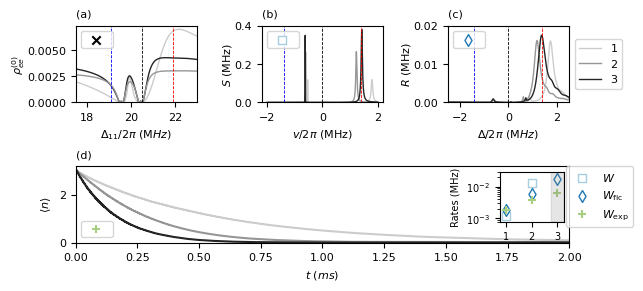

In [123]:
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams.update({'font.size': 8})
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax4%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(constrained_layout=True,figsize=(5.8,2.8))

gs = GridSpec(2, 3, figure=fig)
#gs.update(wspace=0.005, hspace=0.005)

# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))


ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title(r'(a)',loc='left',fontdict={'fontsize': 8})
ax1.plot(np.linspace(Dmin,Dmax,NN),pope,color='#cccccc',linewidth=1)
ax1.plot(np.linspace(Dmin,Dmax,NN),pope2,color='#252525',linewidth=1)
ax1.plot(np.linspace(Dmin,Dmax,NN),pope1,color='#969696',linewidth=1)
ax1.axvline(Delta_ds[-2]+1.4, linestyle='--',color='red',linewidth=0.6)
ax1.axvline(Delta_ds[-2], linestyle='--',color='black',linewidth=0.6)
ax1.axvline(Delta_ds[-2]- 1.4, linestyle='--',color='blue',linewidth=0.6)
ax1.scatter([3],2*wabs[-1],marker='x',label='$\,$',color='black')
ax1.set_xlim(17.5,23)
ax1.set_ylim(0)
ax1.set_ylabel(r'$\rho_{ee}^{(0)}$',labelpad=0)
ax1.set_xlabel('$Δ_{11}/2π \ (ΜHz)$')
ax1.legend(loc='upper left',alignment='left',handletextpad=0.05,borderpad=0.3)
#ax1.ticklabel_format(axis='y', scilimits=[-3, -2])
#plt.ylim(0)


ax3 = fig.add_subplot(gs[0, 1])
ax3.set_title(r'(b)',loc='left',fontdict={'fontsize': 8})
ax3.plot(np.linspace(-2,2,1000),Ss,color='#cccccc',linewidth=1)
ax3.plot(np.linspace(-2,2,1000),Ss2,color='#969696',linewidth=1)
ax3.plot(np.linspace(-2,2,1000),Ss1,color='#252525',linewidth=1)
ax3.scatter([1],w.real[-1] +10,marker='s',label=r'$\,$',color='white',edgecolor = '#a6cee3')
ax3.set_ylabel('$S$ (MHz)',labelpad=0)
ax3.set_xlabel('$v/2π$ (ΜHz)')
ax3.set_ylim(0,0.4)
ax3.axvline(1.4, linestyle='--',color='red',linewidth=0.6)
ax3.axvline(0, linestyle='--',color='black',linewidth=0.6)
ax3.axvline(- 1.4, linestyle='--',color='blue',linewidth=0.6)
ax3.legend(loc='upper left',alignment='left',handletextpad=0.05,borderpad=0.3)
#ax3.legend(loc='center left',prop={'size': 8},bbox_to_anchor=(1, 0.5))

ax2 = fig.add_subplot(gs[0, 2])
ax2.set_title(r'(c)',loc='left',fontdict={'fontsize': 8})
line1,=ax2.plot(np.linspace(Dmin_,Dmax_,nn_),abs,color='#cccccc',label='1',linewidth=1)
line2,=ax2.plot(np.linspace(Dmin_,Dmax_,nn_),abs2,color='#969696',label='2',linewidth=1)
line3,=ax2.plot(np.linspace(Dmin_,Dmax_,nn_),abs1,color='#252525',label='3',linewidth=1)
line4=ax2.scatter([1,2,3],w_tilde.real+10,marker='d',label=r'$\,$',color='white',edgecolor = '#1f78b4')
ax2.axvline(1.4, linestyle='--',color='red',linewidth=0.6)
ax2.axvline(0, linestyle='--',color='black',linewidth=0.6)
ax2.axvline( - 1.4, linestyle='--',color='blue',linewidth=0.6)
ax2.set_ylabel('$R$ (MHz)',labelpad=0)
ax2.set_xlabel('$Δ/2π \ (ΜHz)$')
ax2.set_ylim(0,0.02)
ax2.set_xlim(-2.5,2.5)
#ax2.ticklabel_format(axis='y', scilimits=[-4, -3])
ax2.legend(loc='center left',prop={'size': 8},bbox_to_anchor=(1, 0.5))
first_legend =plt.legend(handles=[line1,line2,line3],loc='center left',prop={'size': 8},bbox_to_anchor=(1, 0.5))
ax2.add_artist(first_legend)
second_legend = plt.legend(handles=[line4],loc='upper left',alignment='left',handletextpad=0.05,borderpad=0.3)

ax4 = fig.add_subplot(gs[1, :])
ax4.set_title(r'(d)',loc='left',fontdict={'fontsize': 8})
ax4.errorbar(t[0]*1e-3,nMC,yerr = nMC_dev,color='#cccccc',ecolor='#cccccc')
ax4.errorbar(t2[0]*1e-3,nMC2,yerr = nMC_dev2,color='#969696',ecolor='#969696')
ax4.errorbar(t1[0]*1e-3,nMC1,yerr = nMC_dev1,color='#252525',ecolor='#252525')
ax4.scatter([1,2,3],np.array(w_exp)+10,marker='+',label=r'$\,$',color='#a7cf82')
ax4.set_ylabel(r'$ \langle n \rangle $')
ax4.set_xlabel(r'$t \ (ms)$')
ax4.set_ylim(0,3.2)
ax4.set_xlim(0,2)
#plt.xlim(0,100)
#ax4.legend(prop={'size': 10})
ax4.legend(loc='lower left',alignment='left',handletextpad=0.05,borderpad=0.3,columnspacing=0.05)


inset_ax = inset_axes(ax4, width="13%", height=0.5, loc="upper right")
#inset_ax.set_title(r'(e)',loc='left',fontdict={'fontsize': 8},pad=5)
#inset_ax.fill_between(np.linspace(2.75,3.25,1000),y1=1e-4,y2=1, color='grey', alpha=0.2)
inset_ax.scatter([1,2,3],w,marker='s',label=r'$W$',color='white',edgecolor = '#a6cee3')
inset_ax.scatter([1,2,3],w_tilde,marker='d',label=r'$W_{\text{fic}}$',color='white',edgecolor = '#1f78b4')
inset_ax.scatter([1,2,3],w_exp,marker='+',label=r'$W_{\text{exp}}$',color='#a7cf82')
#inset_ax.scatter([1,2,3],2*wabs,marker='x',label=r'$W_{\text{abs}}$',color='black')
inset_ax.set_xticks([1,2,3])
inset_ax.set_xticklabels(["1","2","3"])
inset_ax.set_ylim(8e-4,3e-2)
inset_ax.set_xlim(0.75,3.25)
inset_ax.tick_params(labelsize=7)
inset_ax.fill_between(np.linspace(2.75,3.25,1000),y1=8e-4,y2=3e-2, color='grey', alpha=0.2)
inset_ax.set_yscale('log')
inset_ax.set_ylabel('Rates (MHz)',fontsize=7)
inset_ax.legend(loc='center left',prop={'size': 8},bbox_to_anchor=(0.95, 0.5))
#ax4.set_xlabel('Cases')
#plt.xticks([]); plt.yticks([])  # strip ticks, which collide w/ main ax


#ax4 = fig.add_subplot(gs[2:, :2])
#ax4.set_title(r'(d)',loc='left',fontdict={'fontsize': 10}, pad=10)
#ax4.scatter([1,2,3],w,marker='o',label='$W$',color=['black','royalblue','lightblue'])
#ax4.scatter([1,2,3],w_tilde,marker='*',label='$\widetilde{W}$',color=['black','royalblue','lightblue'])
#ax4.scatter([1,2,3],w_exp,marker='p',label='$W_{exp}$',color=['black','royalblue','lightblue'])
#ax4.set_xticks([1,2,3])
#ax4.set_xticklabels(["1","2","3"])
#ax4.set_yscale('log')


#ax4.set_ylabel('Cooling Rates (MHz)')
#ax4.set_xlabel('Cases')

#ax4.legend(loc='center left',prop={'size': 8},bbox_to_anchor=(1, 0.5))
#plt.xlim(45,55)

#fig.suptitle("GridSpec")
#format_axes(fig)


plt.savefig("I1_all.pdf",bbox_inches = "tight")

plt.show()